In [1]:
import os
import glob
import re
import datetime
from datetime import date, time, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from itertools import chain
from cv2 import VideoCapture, CAP_PROP_FRAME_COUNT, CAP_PROP_FPS, CAP_PROP_POS_FRAMES
import cv2
from PIL import Image
import ffmpeg
from imutils.video import FileVideoStream
import imutils
import time
import glob
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Span, DatetimeTicker, DatetimeTickFormatter
import pytesseract

sns.set()
output_notebook()

Loading BokehJS ...

In [20]:
def mask_rh_corner(frame, w, h):
    if not (isinstance(w, (float, int)) and isinstance(h, (float, int))):
        raise ValueError(f"w and h must both be float or int type, instead got w: {type(w)}, h: {type(h)}")
    if isinstance(w, float):
        w = int(frame.shape[1] * (1 - w))
    if isinstance(h, float):
        h = int(frame.shape[0] * h)

    frame[:h, w:, :] = 0
    
    return frame

# Set video variables and build paths

In [11]:
#meeting_id = 160320
#meeting_id = 83512718053
meeting_id = 220120
#meeting_id = 170127

In [12]:
video_path = glob.glob(f'zoom_data/{meeting_id}/*.mp4')[0]
print(video_path)
diff_path = f'diff_data/diffs_{meeting_id}_pct_masked_cossim.csv'
sc_labels = f'slide_change_labels/{meeting_id}.csv'

zoom_data/220120/GMT20210614-220120_Recording_1920x1170.mp4


# Load Video

In [13]:
vidcap = VideoCapture(video_path)

In [14]:
fps = vidcap.get(CAP_PROP_FPS)
fps

25.0

# View frame

- Word count
- Avergage reading speed
- Table with slide and flag those where instructor went too fast
- Summary table
  - What's on the slides
  - How much time
  - etc....

In [21]:
## 83512718053:  26343 (noise), 26353 (slide change), 26404 (noise), 18744 (noise)
vidcap.set(1, 18744)

True

In [23]:
success, f = vidcap.read()
f = mask_rh_corner(f, 0.17, 0.16)

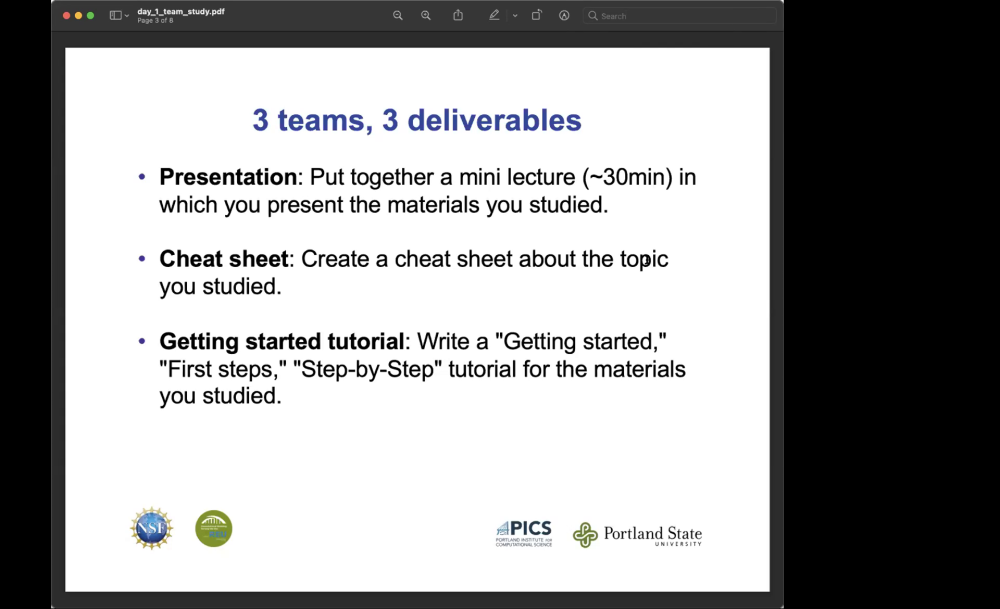

In [24]:
color_coverted = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
pil_image_resized = Image.fromarray(imutils.resize(color_coverted, width=1000))
display(pil_image_resized)

## String output

In [25]:
print(pytesseract.image_to_string(color_coverted))

we ee
eres

¢ 5s AaAIIVAaArandi
s, 3 deliverak

¢ Presentation: Put together a mini lecture (~30min) in
which you present the materials you studied.

¢ Cheat sheet: Create a cheat sheet about the topic
you studied.

¢ Getting started tutorial: Write a "Getting started,"
"First steps,” "Step-by-Step" tutorial for the materials
you studied.

 



In [26]:
print(pytesseract.image_to_string(color_coverted, config=r'--psm 6'))

Cea aaa CU UE UY = OC
3 teams, 3 deliverables

¢ Presentation: Put together a mini lecture (~30min) in
which you present the materials you studied.

¢ Cheat sheet: Create a cheat sheet about the topic
you studied.

¢ Getting started tutorial: Write a "Getting started,"
"First steps,” "Step-by-Step" tutorial for the materials
you studied.

BSS & IPICS GH Portland State



## Data output

In [138]:
df = pytesseract.image_to_data(color_coverted, output_type='data.frame')
df['text_area'] = df.width * df.height

In [139]:
text_df = df.loc[(df.text.notna()) & (df.text.str.strip() != ''), :]
text_df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,text_area
4,5,1,1,1,1,1,240,28,7,4,25,we,28
5,5,1,1,1,1,2,264,16,167,14,18,ee,2338
7,5,1,1,1,2,1,211,21,121,25,20,eres,3025
11,5,1,2,1,1,1,746,230,17,12,92,3,204
12,5,1,2,1,1,2,785,209,199,41,38,deliverz,8159
16,5,1,3,1,1,1,267,335,11,10,78,¢,110
17,5,1,3,1,1,2,309,323,271,32,96,Presentation:,8672
18,5,1,3,1,1,3,598,323,63,32,96,Put,2016
19,5,1,3,1,1,4,673,323,160,41,96,together,6560
20,5,1,3,1,1,5,846,331,22,24,96,a,528


In [140]:
text_area = text_df.text_area.sum()
text_area

182723

In [141]:
frame_area = f.shape[0] * f.shape[1]
frame_area

2246400

In [142]:
text_area / frame_area

0.08134036680911681

## Boxes output

In [92]:
print(pytesseract.image_to_boxes(color_coverted))

C 248 1348 257 1358 0
T 259 1345 279 1358 0
T 278 1345 388 1361 0
e 314 1341 326 1365 0
l 320 1341 332 1365 0
e 346 1345 362 1361 0
l 356 1345 384 1361 0
a 384 1341 396 1365 0
r 253 1330 257 1340 0
a 253 1336 256 1338 0
r 264 1330 266 1340 0
) 271 1330 275 1340 0
* 348 876 360 888 0
S 376 866 395 895 0
u 399 866 417 888 0
p 423 858 442 888 0
p 428 858 460 895 0
o 447 858 466 888 0
r 470 866 490 888 0
t 495 866 522 893 0
( 537 858 545 898 0
p 537 858 568 898 0
r 551 858 587 888 0
o 589 866 609 888 0
j 610 858 619 896 0
e 624 866 643 888 0
c 646 866 662 888 0
t 664 866 678 893 0
t 690 866 704 893 0
e 706 866 725 888 0
a 728 866 745 888 0
m 740 860 772 893 0
s 752 866 781 888 0
, 786 860 811 888 0
s 826 866 841 888 0
c 828 860 860 897 0
i 844 866 870 896 0
e 874 866 893 888 0
n 880 860 912 897 0
t 898 866 916 888 0
i 919 866 933 893 0
f 936 866 941 896 0
i 945 866 966 897 0
c 970 866 986 888 0
, 989 860 997 872 0
t 1010 866 1045 893 0
e 1028 860 1060 897 0
c 1049 866 1065 888 0
h 1069 866